# Cell-free and in vivo characterization of LuxR, LasR, and RpaR activation Systems 
## Data anlysis notebook 

This jupyter notebook serves to reproduce all of the figures published in "Cell-free and in vivo characterization of LuxR, LasR, and RpaR activation systems" by Halleran and Murray, 2017. 

All analysis is performed in Python 3.5 using Anaconda. 

All data can be found in the Data directory of this git repository. 

In [155]:
#First we are going to import all of the packages we need for the entirety of the notebook. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
# This sets default backgrounds for our seaborn plots to make them look a bit nicer. 
rcParams.update({'figure.autolayout': True})
rc={'lines.linewidth': 4, 'axes.labelsize': 24, 'axes.titlesize': 24}

First we want to recreate figure 1, part A through D. 

Figure 1A is a time trace off a BioTek H1M. The data for this file is in /Data/(RpaR link here). 

Below we are going to write a function for taking a series of wells and plotting a linegraph with standard deviation. Then we are going to pass in all of our wells from the figure and create a formatted plot at the end. 

## Figure 1A 

In [156]:
def plotWells(wells, gain, tag, color):
	allWells = []
	for well in wells: 
		wellData = flxData[flxData['Well'] == well]
		wellData = wellData[wellData['Gain'] == gain]
		time = wellData.loc[:, 'Time (hr)']
		allWells.append(wellData.uM)

	wellArray = (allWells[0], allWells[1], allWells[2], allWells[3])
	mean = np.mean(wellArray, axis=0)
	std = np.std(wellArray, axis=0)
	below_mean = np.subtract(mean, std)
	above_mean = np.add(mean, std)
	plt.fill_between(time, below_mean, above_mean, alpha=0.4, color=color)
	plt.plot(time, mean, color=color, label=tag)

Now we are going to load in our fluorescence data from the BioTek. We are using already tidy format data, for a package to tidy raw data please see github.com/sclamons/murraylab_tools 

In [157]:
flxData = pd.read_csv('Data/170529_RpaR_CT_Trial_tidy.csv')

For this plot we want to plot RpaR with pRpa with different concentrations of Rpa ligand (p-coumaroyl). Those wells are: 
I-P, 9-12. Each row is a different amount of AHL, each column is a replicate experiment. I is the negative control (DMSO only), and then we go from high concentraiton (100uM) in J to low concentration in P. 

Let's plot that out. 

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


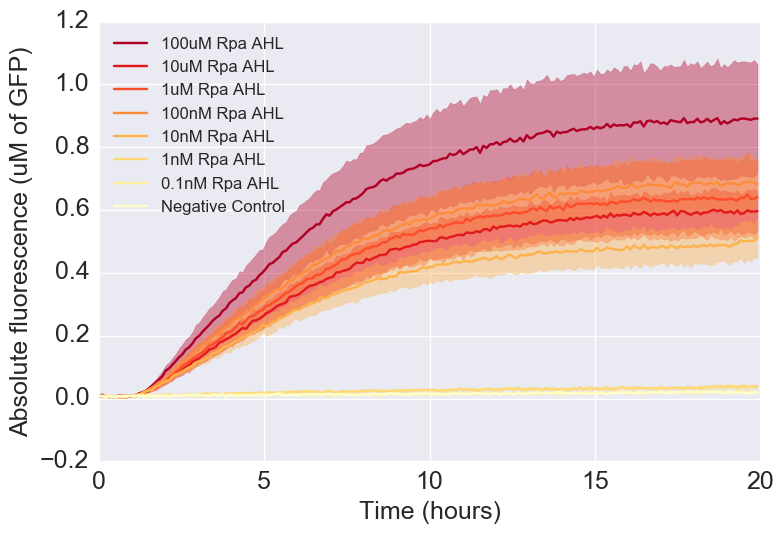

In [158]:
# Identify the wells we want to plot 
well1 = '9'
well2 = '10'
well3 = '11'
well4 = '12'

# Tell the plotting script what AHL we are using

AHL = 'Rpa'

# Call the plotWells function
plotWells(['J' + well1, 'J' + well2, 'J' + well3, 'J' + well4], 61, '100uM ' + AHL + ' AHL', '#b10026')
plotWells(['K' + well1, 'K' + well2, 'K' + well3, 'K' + well4], 61, '10uM ' + AHL + ' AHL', '#e31a1c')
plotWells(['L' + well1, 'L' + well2, 'L' + well3, 'L' + well4], 61, '1uM ' + AHL + ' AHL', '#fc4e2a')
plotWells(['M' + well1, 'M' + well2, 'M' + well3, 'M' + well4], 61, '100nM ' + AHL +  ' AHL', '#fd8d3c')
plotWells(['N' + well1, 'N' + well2, 'N' + well3, 'N' + well4], 61, '10nM ' + AHL +  ' AHL', '#feb24c')
plotWells(['O' + well1, 'O' + well2, 'O' + well3, 'O' + well4], 61, '1nM ' + AHL +  ' AHL', '#fed976')
plotWells(['P' + well1, 'P' + well2, 'P' + well3, 'P' + well4], 61, '0.1nM ' + AHL +  ' AHL', '#ffeda0')
plotWells(['I' + well1, 'I' + well2, 'I' + well3, 'I' + well4], 61, 'Negative Control', '#ffffcc')

# Time to format the plot to make it a little bit cleaner
plt.xlabel('Time (hours)', fontsize=18)
plt.ylabel('Absolute fluorescence (uM of GFP)', fontsize=18)
plt.legend(loc='upper left', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

## Figures 1B-D

Now that we have an example trace the next thing we want to look at is crosstalk heatmaps from our TX-TL data. This is going to consist of four main steps:
    1. Calculate the maximum fluorescence across the time series 
    2. Subtract background fluorescence
    3. Normalize all measurements for a given transcription factor to the highest expression observed
    4. Plot the heatmap
    
Figure 1B is LuxR data, so we're going to first load that in

In [159]:
flxData = pd.read_csv('Data/170526_LuxR_CT_Trial_Tidy.csv')

Now we are going to use a function that will return the 95th percentile value across a given time series. 

Because we have replicates (N=4 for all TX-TL crosstalk experiments), we are going to pass the four wells we are interested in to the function and it is going to return the mean of the 95th percentiles for each of the four wells. 


In [160]:
def get95(wells, gain, negativeControl=0):
    percentileValues = []
    # Iterate over all wells passed, append the 95th percentile value from each well to the list of all 
    # 95th percentiles
    for well in wells: 
        wellData = flxData[flxData['Well'] == well]
        wellData = wellData[wellData['Gain'] == gain]
        maxFlx = np.percentile(wellData.uM.values, 95)
        percentileValues.append(maxFlx)
    return np.mean(np.array(percentileValues))-negativeControl



In [161]:
# Now we're going to run this function for the nine condtions we need
negativeControl = get95(['L13', 'L14', 'L15', 'L16'], 61)
LuxR_pLux_LuxAHL = get95(['D13', 'D14', 'D15', 'D16'], 61, negativeControl)
LuxR_pLux_LasAHL = get95(['D17', 'D18', 'D19', 'D20'], 61, negativeControl)
LuxR_pLux_RpaAHL = get95(['D21', 'D22', 'D23', 'D24'], 61, negativeControl)
LuxR_pLas_LuxAHL = get95(['D1', 'D2', 'D3', 'D4'], 61, negativeControl)
LuxR_pLas_LasAHL = get95(['D5', 'D6', 'D7', 'D8'], 61, negativeControl)
LuxR_pLas_RpaAHL = get95(['D9', 'D10', 'D11', 'D12'], 61, negativeControl)
LuxR_pRpa_LuxAHL = get95(['L1', 'L2', 'L3', 'L4'], 61, negativeControl)
LuxR_pRpa_LasAHL = get95(['L5', 'L6', 'L7', 'L8'], 61, negativeControl)
LuxR_pRpa_RpaAHL = get95(['L9', 'L10', 'L11', 'L12'], 61, negativeControl)
negativeControl

0.0081822202565236639

In [162]:
# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. 
firstRow = np.array([LuxR_pLux_LuxAHL, LuxR_pLux_LasAHL, LuxR_pLux_RpaAHL]).clip(0)
secondRow = np.array([LuxR_pLas_LuxAHL, LuxR_pLas_LasAHL, LuxR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([LuxR_pRpa_LuxAHL, LuxR_pRpa_LasAHL, LuxR_pRpa_RpaAHL]).clip(0)

heatmapVector = [firstRow, secondRow, thirdRow]
heatmapVector = [secondRow, firstRow, thirdRow]
heatmapVector = np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector))

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


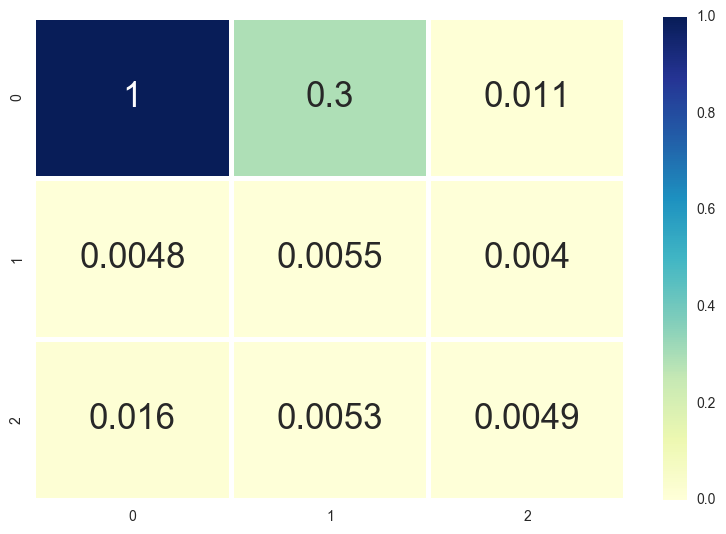

In [163]:
# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

We'll fix the labels in photoshop, but this is the core of figure 1B. Time to make the same graphs but for 1C, and 1D. 

1C is LasR data so we need to load in a new file. Once we do that we are going to run almost exactly what we did above for figure 1B. 

In [164]:
# Load in the flx data for LasR 
flxData = pd.read_csv('Data/170530_LasR_CT_Trial_Tidy.csv')

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


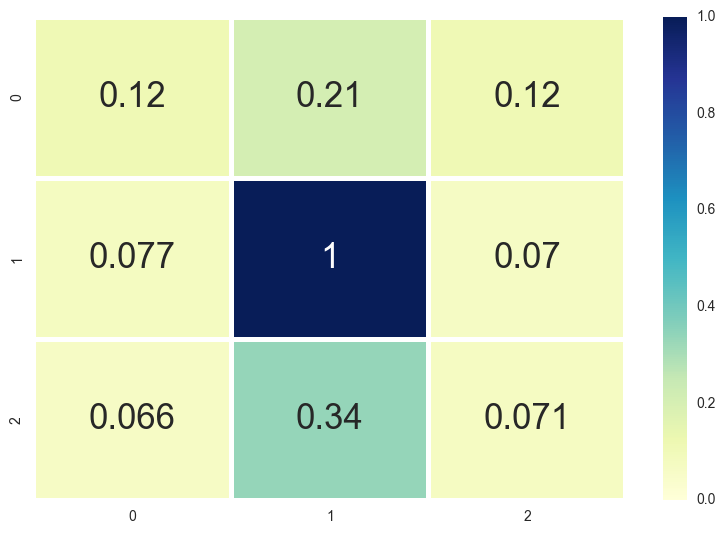

In [165]:
negativeControl = get95(['L13', 'L14', 'L15', 'L16'], 61)
LasR_pLux_LuxAHL = get95(['D1', 'D2', 'D3', 'D4'], 61, negativeControl)
LasR_pLux_LasAHL = get95(['D5', 'D6', 'D7', 'D8'], 61, negativeControl)
LasR_pLux_RpaAHL = get95(['D9', 'D10', 'D11', 'D12'], 61, negativeControl)
LasR_pLas_LuxAHL = get95(['D13', 'D14', 'D15', 'D16'], 61, negativeControl)
LasR_pLas_LasAHL = get95(['D17', 'D18', 'D19', 'D20'], 61, negativeControl)
LasR_pLas_RpaAHL = get95(['D21', 'D22', 'D23', 'D24'], 61, negativeControl)
LasR_pRpa_LuxAHL = get95(['L1', 'L2', 'L3', 'L4'], 61, negativeControl)
LasR_pRpa_LasAHL = get95(['L5', 'L6', 'L7', 'L8'], 61, negativeControl)
LasR_pRpa_RpaAHL = get95(['L9', 'L10', 'L11', 'L12'], 61, negativeControl)

# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. 
firstRow = np.array([LasR_pLux_LuxAHL, LasR_pLux_LasAHL, LasR_pLux_RpaAHL]).clip(0)
secondRow = np.array([LasR_pLas_LuxAHL, LasR_pLas_LasAHL, LasR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([LasR_pRpa_LuxAHL, LasR_pRpa_LasAHL, LasR_pRpa_RpaAHL]).clip(0)

heatmapVector = [firstRow, secondRow, thirdRow]
heatmapVector = [secondRow, firstRow, thirdRow]
heatmapVector = np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector))

# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

In [166]:
# Load in the RpaR data
flxData = flxData = pd.read_csv('Data/170529_RpaR_CT_Trial_Tidy.csv')

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


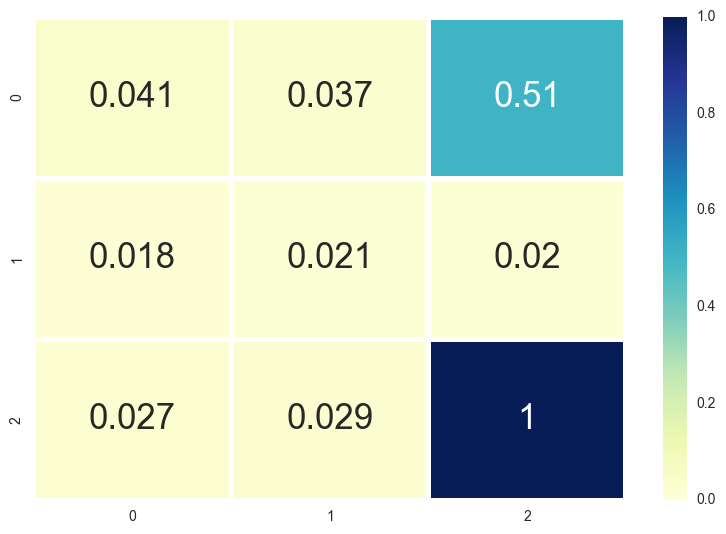

In [167]:
negativeControl = get95(['L13', 'L14', 'L15', 'L16'], 61)
RpaR_pLux_LuxAHL = get95(['D1', 'D2', 'D3', 'D4'], 61, negativeControl)
RpaR_pLux_LasAHL = get95(['D5', 'D6', 'D7', 'D8'], 61, negativeControl)
RpaR_pLux_RpaAHL = get95(['D9', 'D10', 'D11', 'D12'], 61, negativeControl)
RpaR_pLas_LuxAHL = get95(['D13', 'D14', 'D15', 'D16'], 61, negativeControl)
RpaR_pLas_LasAHL = get95(['D17', 'D18', 'D19', 'D20'], 61, negativeControl)
RpaR_pLas_RpaAHL = get95(['D21', 'D22', 'D23', 'D24'], 61, negativeControl)
RpaR_pRpa_LuxAHL = get95(['L1', 'L2', 'L3', 'L4'], 61, negativeControl)
RpaR_pRpa_LasAHL = get95(['L5', 'L6', 'L7', 'L8'], 61, negativeControl)
RpaR_pRpa_RpaAHL = get95(['L9', 'L10', 'L11', 'L12'], 61, negativeControl)

# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. 
firstRow = np.array([RpaR_pLux_LuxAHL, RpaR_pLux_LasAHL, RpaR_pLux_RpaAHL]).clip(0)
secondRow = np.array([RpaR_pLas_LuxAHL, RpaR_pLas_LasAHL, RpaR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([RpaR_pRpa_LuxAHL, RpaR_pRpa_LasAHL, RpaR_pRpa_RpaAHL]).clip(0)

heatmapVector = [firstRow, secondRow, thirdRow]
heatmapVector = [secondRow, firstRow, thirdRow]
heatmapVector = np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector))

# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

## Figure 2A-C

Now that we have reproduced figure 1, subplots A-D, we can move on to figure 2. 

The first set of figures we're going to make are the in vivo crosstalk heatmaps. These are going to be very similar to the plots provided above, but now we need to normalize our GFP readings by OD before we can create our heatmap. Our negative control well for these experiments is a set of three wells (each a distinct colony) that instead of being induced by an AHL are in media containing the same final % of DMSO. 

However, our main steps are still very similar to what they were above. Briefly: 

    1. Calculate the maximum fluorescence / OD across the time series
    2. Subtract background fluorescence (calculated from DMSO only wells) 
    3. Normalize all measurements for a given transcription factor to the highest expression observed
    4. Plot the heatmap

We're going to start with LuxR data, as before. This experiment was split across two different BioTeks which means we have two files we need to pull from, and two different sets of negative control wells. That makes the analysis code a bit longer, but same exact concept as what's going to follow for 2B and 2C. 

In [168]:
flxData1 = pd.read_csv('Data/170601_invivo_CT_panel_Tidy.csv')
flxData2 = pd.read_csv('Data/170613_LuxR_pLas_CT_experiment_tidy.csv')

In [169]:
def get95_ODNormalized(wells, gain1, gain2, dataFile, negativeControl=0):
    percentileValues = []
    # Iterate over all wells passed, append the 95th percentile value from each well to the list of all 
    # 95th percentiles
    for well in wells: 
        wellData = dataFile[dataFile['Well'] == well]
        wellDataGFP = wellData[wellData['Gain'] == gain1]
        wellDataOD = wellData[wellData['Gain']==gain2]
        wellDataGFPNorm = (wellDataGFP.AFU.values)/(wellDataOD.AFU.values)
        maxFlx = np.percentile(wellDataGFPNorm, 95)
        percentileValues.append(maxFlx)
    return np.mean(np.array(percentileValues))-negativeControl

LuxR_pLux_neg = get95_ODNormalized(['A10', 'A11', 'A12'], 61, -1, flxData1)
LuxR_pLas_neg = get95_ODNormalized(['D10', 'D11', 'D12'], 61, -1, flxData2)
LuxR_pRpa_neg = get95_ODNormalized(['B10', 'B11', 'B12'], 61, -1, flxData1)
LasR_pLux_neg = get95_ODNormalized(['C10', 'C11', 'C12'], 61, -1, flxData1)
LasR_pLas_neg = get95_ODNormalized(['D10', 'D11', 'D12'], 61, -1, flxData1)
LasR_pRpa_neg = get95_ODNormalized(['E10', 'E11', 'E12'], 61, -1, flxData1)
RpaR_pLux_neg = get95_ODNormalized(['F10', 'F11', 'F12'], 61, -1, flxData1)
RpaR_pLas_neg = get95_ODNormalized(['G10', 'G11', 'G12'], 61, -1, flxData1)
RpaR_pRpa_neg = get95_ODNormalized(['H10', 'H11', 'H12'], 61, -1, flxData1)

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


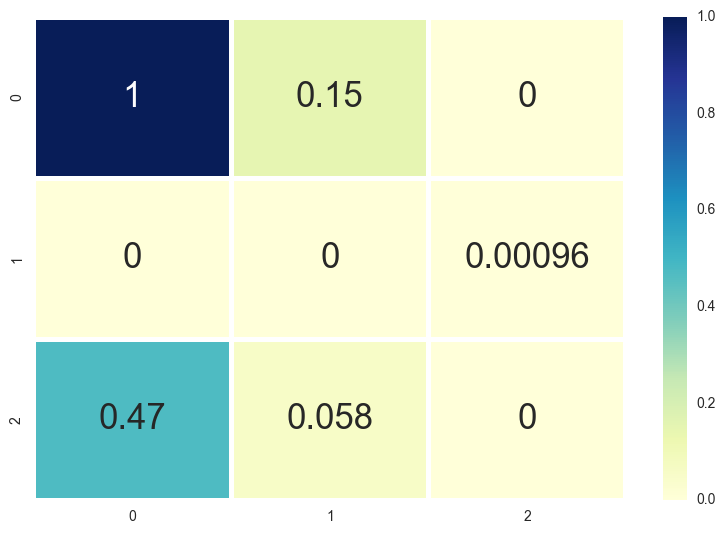

In [170]:
# Now that we have all of our negative control values we can get our experimental data results. 
# First plot is again for LuxR. 

LuxR_pLux_LuxAHL = get95_ODNormalized(['A1', 'A2', 'A3'], 61, -1, flxData1, LuxR_pLux_neg)
LuxR_pLux_LasAHL = get95_ODNormalized(['A4', 'A5', 'A6'], 61, -1, flxData1, LuxR_pLux_neg)
LuxR_pLux_RpaAHL = get95_ODNormalized(['A7', 'A8', 'A9'], 61, -1, flxData1, LuxR_pLux_neg)
LuxR_pLas_LuxAHL = get95_ODNormalized(['D1', 'D2', 'D3'], 61, -1, flxData2, LuxR_pLas_neg)
LuxR_pLas_LasAHL = get95_ODNormalized(['D4', 'D5', 'D6'], 61, -1, flxData2, LuxR_pLas_neg)
LuxR_pLas_RpaAHL = get95_ODNormalized(['D7', 'D8', 'D9'], 61, -1, flxData2, LuxR_pLas_neg)
LuxR_pRpa_LuxAHL = get95_ODNormalized(['B1', 'B2', 'B3'], 61, -1, flxData1, LuxR_pRpa_neg)
LuxR_pRpa_LasAHL = get95_ODNormalized(['B4', 'B5', 'B6'], 61, -1, flxData1, LuxR_pRpa_neg)
LuxR_pRpa_RpaAHL = get95_ODNormalized(['B7', 'B8', 'B9'], 61, -1, flxData1, LuxR_pRpa_neg)

# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. 
firstRow = np.array([LuxR_pLux_LuxAHL, LuxR_pLux_LasAHL, LuxR_pLux_RpaAHL]).clip(0)
secondRow = np.array([LuxR_pLas_LuxAHL, LuxR_pLas_LasAHL, LuxR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([LuxR_pRpa_LuxAHL, LuxR_pRpa_LasAHL, LuxR_pRpa_RpaAHL]).clip(0)

heatmapVector = [firstRow, secondRow, thirdRow]
heatmapVector = [secondRow, firstRow, thirdRow]
heatmapVector = np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector))

# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


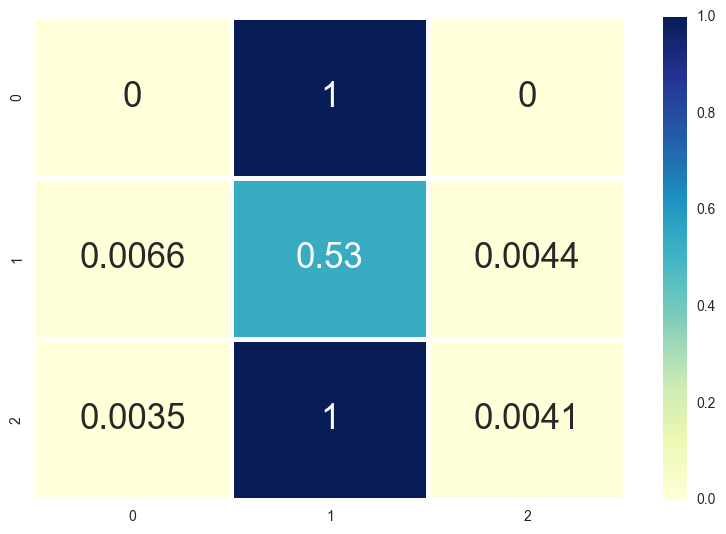

In [171]:
# Time to do the same for LasR
LasR_pLux_LuxAHL = get95_ODNormalized(['C1', 'C2', 'C3'], 61, -1, flxData1, LasR_pLux_neg)
LasR_pLux_LasAHL = get95_ODNormalized(['C4', 'C5', 'C6'], 61, -1, flxData1, LasR_pLux_neg)
LasR_pLux_RpaAHL = get95_ODNormalized(['C7', 'C8', 'C9'], 61, -1, flxData1, LasR_pLux_neg)
LasR_pLas_LuxAHL = get95_ODNormalized(['D1', 'D2', 'D3'], 61, -1, flxData1, LasR_pLas_neg)
LasR_pLas_LasAHL = get95_ODNormalized(['D4', 'D5', 'D6'], 61, -1, flxData1, LasR_pLas_neg)
LasR_pLas_RpaAHL = get95_ODNormalized(['D7', 'D8', 'D9'], 61, -1, flxData1, LasR_pLas_neg)
LasR_pRpa_LuxAHL = get95_ODNormalized(['E1', 'E2', 'E3'], 61, -1, flxData1, LasR_pRpa_neg)
LasR_pRpa_LasAHL = get95_ODNormalized(['E4', 'E5', 'E6'], 61, -1, flxData1, LasR_pRpa_neg)
LasR_pRpa_RpaAHL = get95_ODNormalized(['E7', 'E8', 'E9'], 61, -1, flxData1, LasR_pRpa_neg)

# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. 
firstRow = np.array([LasR_pLux_LuxAHL, LasR_pLux_LasAHL, LasR_pLux_RpaAHL]).clip(0)
secondRow = np.array([LasR_pLas_LuxAHL, LasR_pLas_LasAHL, LasR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([LasR_pRpa_LuxAHL, LasR_pRpa_LasAHL, LasR_pRpa_RpaAHL]).clip(0)

heatmapVector = [firstRow, secondRow, thirdRow]
heatmapVector = np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector))

# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


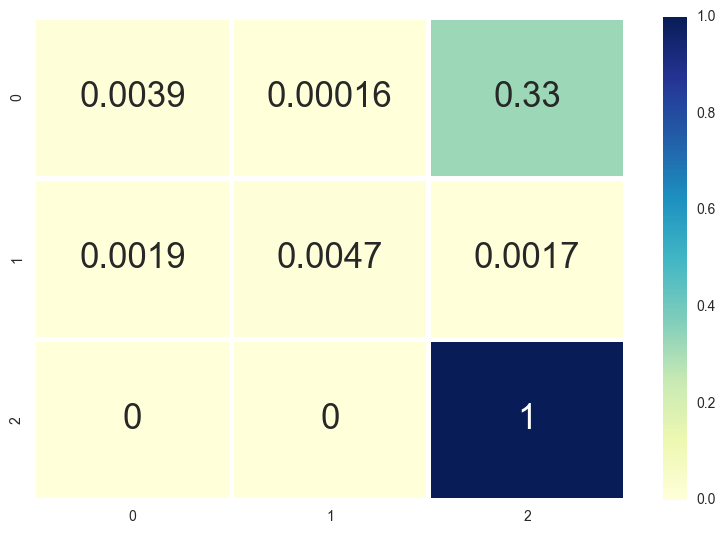

In [184]:
# Time to do the same for RpaR
RpaR_pLux_LuxAHL = get95_ODNormalized(['F1', 'F2', 'F3'], 61, -1, flxData1, RpaR_pLux_neg)
RpaR_pLux_LasAHL = get95_ODNormalized(['F4', 'F5', 'F6'], 61, -1, flxData1, RpaR_pLux_neg)
RpaR_pLux_RpaAHL = get95_ODNormalized(['F7', 'F8', 'F9'], 61, -1, flxData1, RpaR_pLux_neg)
RpaR_pLas_LuxAHL = get95_ODNormalized(['G1', 'G2', 'G3'], 61, -1, flxData1, RpaR_pLas_neg)
RpaR_pLas_LasAHL = get95_ODNormalized(['G4', 'G5', 'G6'], 61, -1, flxData1, RpaR_pLas_neg)
RpaR_pLas_RpaAHL = get95_ODNormalized(['G7', 'G8', 'G9'], 61, -1, flxData1, RpaR_pLas_neg)
RpaR_pRpa_LuxAHL = get95_ODNormalized(['H1', 'H2', 'H3'], 61, -1, flxData1, RpaR_pRpa_neg)
RpaR_pRpa_LasAHL = get95_ODNormalized(['H4', 'H5', 'H6'], 61, -1, flxData1, RpaR_pRpa_neg)
RpaR_pRpa_RpaAHL = get95_ODNormalized(['H7', 'H8', 'H9'], 61, -1, flxData1, RpaR_pRpa_neg)

#RpaR_pLux_LuxAHL = get95_ODNormalized(['F1', 'F2', 'F3'], 61, -1, flxData1)
#RpaR_pLux_LasAHL = get95_ODNormalized(['F4', 'F5', 'F6'], 61, -1, flxData1)
#RpaR_pLux_RpaAHL = get95_ODNormalized(['F7', 'F8', 'F9'], 61, -1, flxData1)
#RpaR_pLas_LuxAHL = get95_ODNormalized(['G1', 'G2', 'G3'], 61, -1, flxData1)
#RpaR_pLas_LasAHL = get95_ODNormalized(['G4', 'G5', 'G6'], 61, -1, flxData1)
#RpaR_pLas_RpaAHL = get95_ODNormalized(['G7', 'G8', 'G9'], 61, -1, flxData1)
#RpaR_pRpa_LuxAHL = get95_ODNormalized(['H1', 'H2', 'H3'], 61, -1, flxData1)
#RpaR_pRpa_LasAHL = get95_ODNormalized(['H4', 'H5', 'H6'], 61, -1, flxData1)
#RpaR_pRpa_RpaAHL = get95_ODNormalized(['H7', 'H8', 'H9'], 61, -1, flxData1)

# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. 
firstRow = np.array([RpaR_pLux_LuxAHL, RpaR_pLux_LasAHL, RpaR_pLux_RpaAHL]).clip(0)
secondRow = np.array([RpaR_pLas_LuxAHL, RpaR_pLas_LasAHL, RpaR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([RpaR_pRpa_LuxAHL, RpaR_pRpa_LasAHL, RpaR_pRpa_RpaAHL]).clip(0)

heatmapVector = [firstRow, secondRow, thirdRow]
heatmapVector = np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector))

# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

## Figure 2D-E

Now we have created the plots for TX-TL traces, TX-TL crosstalk, and in vivo crosstalk. Now we are going to move on to the final two figures which examine the impact of the TF : Reporter DNA ratio for TX-TL mapping. 

The code is very similar to what we used above. Again we are going to get the maximum value out of a timeseries. This is then going to be normalized to the signal of pLux for that given TF concentration. 

In [187]:
flxData = pd.read_csv('Data/170612_Genetic_CT_Titration_tidy.csv')

In [224]:
def get95_Replicates(wells, gain):
    percentileValues = []
    # Iterate over all wells passed, append the 95th percentile value from each well to the list of all 
    # 95th percentiles
    for well in wells: 
        wellData = flxData[flxData['Well'] == well]
        wellData = wellData[wellData['Gain'] == gain]
        maxFlx = np.percentile(wellData.uM.values, 95)
        percentileValues.append(maxFlx)
    return np.array(percentileValues)


pLux_1nM = get95_Replicates(['A1', 'A2', 'A3'], 61)
pLux_1nM = np.divide(pLux_1nM, np.mean(pLux_1nM))

pLux_2nM = get95_Replicates(['B1', 'B2', 'B3'], 61)
pLux_2nM = np.divide(pLux_2nM, np.mean(pLux_2nM))

pLux_4nM = get95_Replicates(['C1', 'C2', 'C3'], 61)
pLux_4nM = np.divide(pLux_4nM, np.mean(pLux_4nM))

pLux_8nM = get95_Replicates(['D1', 'D2', 'D3'], 61)
pLux_8nM = np.divide(pLux_8nM, np.mean(pLux_8nM))

pLux_16nM = get95_Replicates(['E1', 'E2', 'E3'], 61)
pLux_16nM = np.divide(pLux_16nM, np.mean(pLux_16nM))

pLas_1nM = get95_Replicates(['A4', 'A5', 'A6'], 61)
pLas_1nM = np.divide(pLas_1nM, np.mean(pLux_1nM))

pLas_2nM = get95_Replicates(['B4', 'B5', 'B6'], 61)
pLas_2nM = np.divide(pLas_2nM, np.mean(pLux_2nM))

pLas_4nM = get95_Replicates(['C4', 'C5', 'C6'], 61)
pLas_4nM = np.divide(pLas_4nM, np.mean(pLux_4nM))

pLas_8nM = get95_Replicates(['D4', 'D5', 'D6'], 61)
pLas_8nM = np.divide(pLas_8nM, np.mean(pLux_8nM))

pLas_16nM = get95_Replicates(['E4', 'E5', 'E6'], 61)
pLas_16nM = np.divide(pLas_16nM, np.mean(pLux_16nM))

pRpa_1nM = get95_Replicates(['A7', 'A8', 'A9'], 61)
pRpa_1nM = np.divide(pRpa_1nM, np.mean(pLux_1nM))

pRpa_2nM = get95_Replicates(['B7', 'B8', 'B9'], 61)
pRpa_2nM = np.divide(pRpa_2nM, np.mean(pLux_2nM))

pRpa_4nM = get95_Replicates(['C7', 'C8', 'C9'], 61)
pRpa_4nM = np.divide(pRpa_4nM, np.mean(pLux_4nM))

pRpa_8nM = get95_Replicates(['D7', 'D8', 'D9'], 61)
pRpa_8nM = np.divide(pRpa_8nM, np.mean(pLux_8nM))

pRpa_16nM = get95_Replicates(['E7', 'E8', 'E9'], 61)
pRpa_16nM = np.divide(pRpa_16nM, np.mean(pLux_16nM))

def makeDataframe(data, label): 
    df1 = pd.DataFrame([[label, data[0]]], columns=['Constructs', 'Normalized Fluorescence'])
    df2 = pd.DataFrame([[label, data[1]]], columns=['Constructs', 'Normalized Fluorescence'])
    df3 = pd.DataFrame([[label, data[2]]], columns=['Constructs', 'Normalized Fluorescence'])
    dfTemp = pd.concat([df1, df2, df3])
    return dfTemp

pLux_1nM_df = makeDataframe(pLux_1nM, 'pLux_1nM')
pLux_2nM_df = makeDataframe(pLux_2nM, 'pLux_2nM')
pLux_4nM_df = makeDataframe(pLux_4nM, 'pLux_4nM')
pLux_8nM_df = makeDataframe(pLux_8nM, 'pLux_8nM')
pLux_16nM_df = makeDataframe(pLux_16nM, 'pLux_16nM')

pLas_1nM_df = makeDataframe(pLas_1nM, 'pLas_1nM')
pLas_2nM_df = makeDataframe(pLas_2nM, 'pLas_2nM')
pLas_4nM_df = makeDataframe(pLas_4nM, 'pLas_4nM')
pLas_8nM_df = makeDataframe(pLas_8nM, 'pLas_8nM')
pLas_16nM_df = makeDataframe(pLas_16nM, 'pLas_16nM')

pRpa_1nM_df = makeDataframe(pRpa_1nM, 'pRpa_1nM')
pRpa_2nM_df = makeDataframe(pRpa_2nM, 'pRpa_2nM')
pRpa_4nM_df = makeDataframe(pRpa_4nM, 'pRpa_4nM')
pRpa_8nM_df = makeDataframe(pRpa_8nM, 'pRpa_8nM')
pRpa_16nM_df = makeDataframe(pRpa_16nM, 'pRpa_16nM')

finalDf = pd.concat([pLux_1nM_df, pLux_2nM_df, pLux_4nM_df, pLux_8nM_df, pLux_16nM_df,
                     pLas_1nM_df, pLas_2nM_df, pLas_4nM_df, pLas_8nM_df, pLas_16nM_df,
                     pRpa_1nM_df, pRpa_2nM_df, pRpa_4nM_df, pRpa_8nM_df, pRpa_16nM_df])
finalDf

,Constructs,Normalized Fluorescence
0,pLux_1nM,1.254119
0,pLux_1nM,0.808445
0,pLux_1nM,0.937436
0,pLux_2nM,0.795711
0,pLux_2nM,1.251154
0,pLux_2nM,0.953135
0,pLux_4nM,0.686247
0,pLux_4nM,1.483801
0,pLux_4nM,0.829952
0,pLux_8nM,0.801879


/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


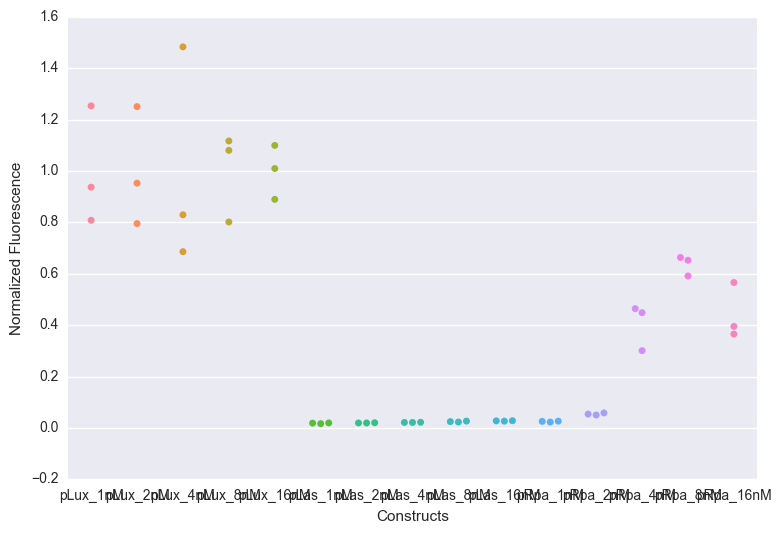

In [226]:
sns.swarmplot(x='Constructs', y='Normalized Fluorescence', data=finalDf)
plt.show()